##Proyecto 1: Predicción de sentimiento de comentario en twitter mediante modelo LSTM##
Para este caso, se eligió una base de datos de kaggle que cuenta con una columna que contiene comentarios de la red social twitter, y en su columna adyacente valores numericos para el sentimiento que se expresa, siendo -1 destinado para sentimientos negativos, 0 para neutrales y 1 para positivos.
Cosas importantes que mencionar es el hecho de que se trabajó con una parte pequeña del dataset(solo 10000 valores de 162000 aproximadamente) para mayor facilidad,se modificaron los valores para sentimientos a 0, 1 y 2 respectivamente para no generar ningun error en la sección de entrenamiento, y se observa que el texto ya ha tenido algun tipo de tratamiento previo, sin embargo, se continuó con la limpieza correspondiente con el fin de evitar cualquier posible valor imprevisto.
Samuel Morales Garrido

##[LINK BASE DE DATOS](https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset/data)##

In [9]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
# 1. Cargar datos
df = pd.read_csv("/content/Twitter_Data.csv", header=None, names=['text', 'sentiment'])
df = df.sample(n=10000, random_state=42)
texts = df["text"].values
labels = df["sentiment"].values
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2, '-1': 0, '0': 0, '1': 1}
labels = df["sentiment"].map(label_mapping).fillna(0).astype(int)
y = np.array(labels)

In [11]:
# 2. Limpieza de texto
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'<[^>]+>', '', texto)
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)
    palabras = texto.split()
    palabras = [lemmatizer.lemmatize(p) for p in palabras if p not in stop_words]
    return " ".join(palabras)

cleaned_texts = [limpiar_texto(t) for t in texts]

In [12]:
# 3. Tokenización
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(cleaned_texts)
sequences = tokenizer.texts_to_sequences(cleaned_texts)
X = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

In [13]:
# 4. División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# 5. Modelo
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
# 6. Entrenamiento
stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
hist = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=64, callbacks=[stop])

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 246ms/step - accuracy: 0.5305 - loss: 0.9380 - val_accuracy: 0.5475 - val_loss: 0.8201
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 222ms/step - accuracy: 0.5332 - loss: 0.8112 - val_accuracy: 0.5475 - val_loss: 0.7525
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 214ms/step - accuracy: 0.5569 - loss: 0.7477 - val_accuracy: 0.5475 - val_loss: 0.7204
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.5710 - loss: 0.7164 - val_accuracy: 0.5475 - val_loss: 0.7005
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 232ms/step - accuracy: 0.7079 - loss: 0.6275 - val_accuracy: 0.7837 - val_loss: 0.5342
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - accuracy: 0.8630 - loss: 0.4279 - val_accuracy: 0.4494 - val_loss: 0.9195
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - accuracy: 0.9024 - loss: 0.3665 - val_accuracy: 0.7831 - val_loss: 0.6170
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 221ms/step - accuracy: 0.9257 - loss: 0

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1110
           1       0.78      0.69      0.73       890

    accuracy                           0.78      2000
   macro avg       0.78      0.77      0.77      2000
weighted avg       0.78      0.78      0.77      2000



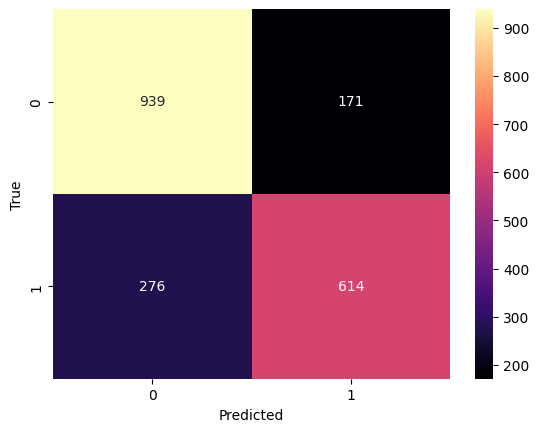

In [18]:
# 7. Evaluación
preds = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

##CONCLUSIONES##
Se logró que modelo alcanzara una precisión del 78% en el conjunto de prueba. Siendo más específicos:

Sentimiento Negativo (Clase 0): 77% de precisión, 85% de recall y un F1-score de 81%.

Sentimiento Neutral (Clase 1): 78% de precisión, 69% de recall y un F1-score de 73%.

Durante el entrenamiento, se usó Early Stopping con una paciencia de 3 épocas para evitar sobreentrenar el modelo. Pudimos notar que la pérdida iba disminuyendo de forma constante, sin embargo, la precisión de validación no fue tan estable: en la época 6, por ejemplo, se desplomó al 44.94%, lo que sugiere cierta inestabilidad en el proceso de aprendizaje.

Aun así, se logró captar bien los patrones del conjunto de entrenamiento, puetso que se logró una precisión del 92.57%, indicando que aprendió con eficacia a pesar que la cantidad de datos reducida que se brindó.

En conclusión, el rendimiento fue equilibrado entre las diferentes clases, aunque todavía hay espacio para mejorar en la clasificación de comentarios neutros. La matriz de confusión mostró que el modelo sigue teniendo dificultades para distinguir entre comentarios negativos y neutros, cosa que podría solucionarse ingresando una mayor cantidad de datos.

